In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import rebound
plt.style.use('paper.mplstyle')
%matplotlib inline

In [3]:
path = '../data/nonressystems/Kepler-431/simulation_archives/runs/'

In [96]:
from rebound.plotting import fading_line

def plot(fig, ax, ID):
    sa = rebound.SimulationArchive(path+'sa{0:07d}.bin'.format(ID))
    sim = sa[0]
    colors = ['red', 'green', 'blue']
    for p,c in zip(sim.particles[1:], colors):
        o = np.array(p.sample_orbit())
        lc = fading_line(o[:,0], o[:,1], linewidth=3, color=c, alpha=0.1)
        ax.add_collection(lc)
    return fig, ax

sa = rebound.SimulationArchive(path+'sa{0:07d}.bin'.format(0))
sim0 = sa[0]
def makesystem(seed, emax):
    random.seed(seed)
    ps = sim0.particles
    sim = rebound.Simulation()
    sim.add(m=ps[0].m)
    for i in [1,2,3]:
        sim.add(m=ps[i].m, a=ps[i].a, e=random.random()*emax, pomega=random.random()*2*np.pi, inc=random.random()*np.pi/180, Omega=random.random()*2*np.pi)
    return sim
    
def predict_stable(seed, emax=0.2):
    sim = makesystem(seed, emax)
    return (seed, sc.predict_stable(sim))
    
def randomplot(fig, ax, seed, emax, alpha=0.1):
    sim = makesystem(seed, emax=emax)
    colors = ['dodgerblue','yellow','crimson']
    for p,c in zip(sim.particles[1:], colors):
        o = np.array(p.sample_orbit())
        ax.plot(o[:,0], o[:,1], linewidth=1, color=c, zorder=0, alpha=alpha)
    return fig, ax

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:86: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:132: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [5]:
%%time
from spock import StabilityClassifier
sc = StabilityClassifier()

CPU times: user 2.97 s, sys: 2.42 s, total: 5.39 s
Wall time: 1.57 s


In [9]:
%%time

try:
    stableseeds = np.loadtxt('prseeds.txt')
except: 
    Nsamp=30000
    res = np.zeros((Nsamp, 2))
    for seed in range(Nsamp):
        res[seed] = predict_stable(seed, emax=0.2)
    
    mask = res[:,1] > 0.01 # discard smallest probabilities to limit # plotted orbits
    stableseeds = res[mask]
    np.savetxt('prseeds.txt', stableseeds)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


CPU times: user 16h 54min 30s, sys: 31min 6s, total: 17h 25min 36s
Wall time: 2h 17min 51s


# 2D array of (seed, stability prob)

In [107]:
stableseeds = np.loadtxt('prseeds.txt')
stableseeds.shape

(3215, 2)

In [106]:
eff_samples = stableseeds[:,1].sum() # add up all probabilities to plot same # of effective samples for equal alpha in both and fair comparison
eff_samples

963.448148121126

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


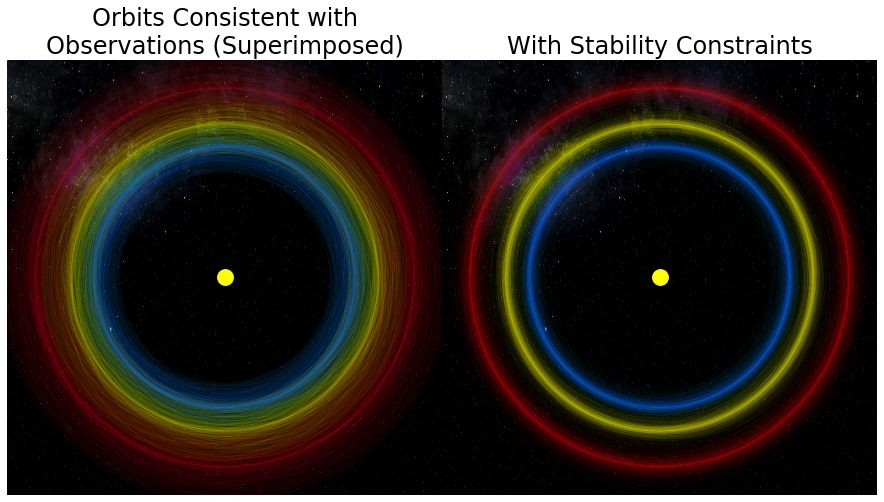

In [108]:
from scipy.misc import imread

fig, axarr = plt.subplots(ncols=2, figsize=(16,8))
plt.subplots_adjust(wspace=-0.05)
lim=0.12

for i in range(int(eff_samples)):
    fig, axarr[0] = randomplot2(fig, axarr[0], i, emax=0.2, alpha=0.02)

for seed, prob in res[mask]:
    fig, axarr[1] = randomplot2(fig, axarr[1], int(seed), emax=0.2, alpha=0.02*prob)

for ax in axarr:
    ax.set_rasterization_zorder(1)
    ax.scatter([0],[0], s=250, color='yellow')
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.axis('off')
    
    bkg = imread('US_background_image.png')
    ax.imshow(bkg, extent=[-lim, lim, -lim, lim], zorder=-1)
    
axarr[0].set_title('Orbits Consistent with\nObservations (Superimposed)')
axarr[1].set_title('With Stability Constraints')
fig.savefig('spockpr.pdf')